In [49]:
# standard imports\n",
import os
import random
import numpy as np

# work with data\n",
import pandas as pd
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import glob
from tqdm.auto import tqdm
from IPython.display import clear_output

# like numpy, only good + NN
import torch, torch.nn as nn
import torch.nn.functional as torch_nn_F
from torch.utils.data import DataLoader, Dataset, Subset
# import torchvision
# from torchvision import transforms
import time


plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab

# Dark plots\n",
#plt.style.use('dark_background')\n",

TIME_STEP = 1
CLASSNAME = {0: 'ballistic', 1: 'hgv', 2: 'hcm'}
CLASSTYPE = {'ballistic': 0, 'hgv': 1, 'hcm': 2}

# Prepare data
## Load and examine data

In [2]:
# Data reading function
def read_trajectories(path_to_file):
    dset = pd.HDFStore(path_to_file, 'r')
#     print(dset.info())\n",
    return dset

## Splitting the data

In [16]:
def train_val_test_split(data, tts = (0.7, 0.1, 0.2), shuffle=False):
    '''Split data into train, validation and test sets according to `tts` tuple

    By default, tts = (train, val, test) = (0.7, 0.1, 0.2)
    '''
    assert sum(tts) == 1

    if shuffle:
        data = np.random.shuffle(data)

    h = len(data)
    train = data[:int(h * tts[0])]
    val = data[int(h * tts[0]) : int(h * np.round(tts[0] + tts[1], 4))]
    test = data[int(h * np.round(tts[0] + tts[1], 4)) : int(h * sum(tts))]

    return train, val, test

In [ ]:
# # example
# len(dset.keys())
# dset[dset.keys()[0]]
# len(np.array(dset[dset.keys()[0]])[:,0])

## Invertible trajectory pre-processing transform

In [18]:
class RelativeTrajectory():
    def __init__(self, df, diff=False, ref_point=20):

        self.diff = diff
        self.ref_point = ref_point
        
        data = np.array(df.drop('t', 1))
        
        # Remember first state
        self.start_state = data[0].copy()
        
        # Make changes relative to the start state
        data -= self.start_state
        
        # Rotate coordinate system around Z axis, 
        # so X` axis will pass through the 20'th point
        # and Y` axis will represent deviation

        ## Calculate angle of rotation: arctan(y_r / x_r), where r is ref_point
        assert data.shape[0] >= ref_point
        self.theta = np.arctan(data[ref_point][1] / data[ref_point][0])

        ## Rotation matrix for XY plane around Z axis
        ## Perform rotation for coordinates
        data[:, :3] = self.rotate_Z(data[:, :3], self.theta)

        ## Perform rotation for velocities
        data[:, 3:6] = self.rotate_Z(data[:, 3:6], self.theta)

        # Scale data to kilometers
        data /= 1000

        self.first_diff_elem = None
        if diff:
            self.first_diff_elem = data[0].copy()
            data = np.diff(data, axis=0)    
        
        self.data = data
        
    def restore(self, columns, ts=1, config=None):
        
        assert ts > 0
        
        if config:
            self.set_info(config)
        
        # Restore diff data
        if self.diff:
            data = np.r_[np.expand_dims(self.first_diff_elem, 0), np.cumsum(self.data, axis=0)]
        else:         
            data = self.data.copy()
        
        # Scale data from km back to meters
        data *= 1000
        
        ## Rotation matrix for XY plane around Z axis
        ## Perform rotation for coordinates
        data[:, 0:3] = self.rotate_Z(data[:, 0:3], -self.theta)

        ## Perform rotation for velocities
        data[:, 3:6] = self.rotate_Z(data[:, 3:6], -self.theta)
        
        # Make changes absolute
        data += self.start_state

        # Restore Pandas.DataFrame format
        t = np.arange(0, data.shape[0], ts)
        data = np.c_[data, t] 
        data = pd.DataFrame(data, columns=columns)
        
        return data
        
    @staticmethod
    def rotate_Z(data, theta):
        """Rotate data around the Z axis using matrix R"""
        
        R = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),  np.cos(theta), 0],
            [            0,              0, 1]
        ])
        return data @ R.T
    
    def info(self):
        return {
            'ref_point' : self.ref_point,
            'diff' : self.diff,
            'start_state' : self.start_state,
            'first_diff_elem' : self.first_diff_elem,
            'theta' : self.theta
        }
    
    def set_info(self, config):
        self.ref_point = config['ref_point']
        self.diff = config['diff']
        self.start_point = config['start_point']
        self.first_diff_elem = config['first_diff_elem']
        self.theta = config['theta']

## Preprocess data for training

In [19]:
def max_min_len_coordinate(dset, keys):
    max_size = 0
    min_size = len(np.array(dset[keys[0]])[:,0])
    for key_k in keys:
        size = len(np.array(dset[key_k])[:,0])
        if size > max_size:
            max_size = size
            max_key = key_k
        if size < min_size:
            min_size = size
            min_key = key_k
    return (max_size, min_size, max_key, min_key)

In [20]:
def get_strided_data_clust(dset, keys, variables=3, gt_size=0, step=1, diff=False, verbose=False):
    '''Return list with parts of trajectories and their residuals.

    Arguments:
    dset -- h5py Data set with trajectory data
        keys -- keys for extracting data from `dset`

    Keyword arguments:
    variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude

        gt_size -- how many trajectory points are to be observed
        step -- (default: 1)
                if 1, every row from the `dset` will be processed,
                if >1, some rows will be skipped accordingly.
        diff -- (default: False) toggle extract differentiated relative trajectories
    '''
    assert gt_size > 1
    assert variables in [3, 6, 7]

    # Create list with parts of trajectories,
    # each element has gt_size trajectory points
    data_seqs = []

    # Set of configs for each trajectory.
    configs = {}

    # List of trajectory indices
    # (to which trajectory this traj_elem belongs to)
    traj_ids = []


    # Collect trajectories, preprocess and
    # split them into trajectory parts
    for k in tqdm(range(len(keys)), disable=1-verbose, desc='Collecting strided data'):
        # Get relative trajectory from the dataset
        rt = RelativeTrajectory(dset[keys[k]], diff=diff)
        configs[k] = rt.info()  # save for future restoration

        # Collect list of trajectory parts from `rt`
        # using time window gt_size and time shift `step`
        if gt_size < rt.data.shape[0]:
            for i in range(1 + (rt.data.shape[0] - gt_size) // step):
                data_seqs.append([rt.data[i*step : i*step + gt_size, :variables]])
                traj_ids.append(k)
        else:
            new_rt = np.zeros((gt_size,variables))  
            new_rt[0:rt.data.shape[0],0:variables] = rt.data[:, :variables]
            data_seqs.append([new_rt])
            traj_ids.append(k)
            
    # Collect all data seqs into one huge dataset
    # of shape [? , gt_size, variables]
    data_seqs_all = np.stack(data_seqs).squeeze()
    traj_ids_all = np.stack(traj_ids)

    # Calculate mean and std over all data
    data_mean = data_seqs_all.mean((0, 1))
    data_std = data_seqs_all.std((0, 1))
    res_mean = np.zeros(variables)
    res_std = np.ones(variables)
    
    
    stats = {
        'data_mean': data_mean,
        'data_std': data_std,
        'res_mean': res_mean,
        'res_std': res_std
    }

    if verbose:
        with np.printoptions(precision=3):
            print(f'Total trajectory parts: {data_seqs_all.shape[0]}')
            print(f'Each: {gt_size} observed = {gt_size} points in total')
            print(f'Each point contains {data_seqs_all.shape[-1]} variables')

            print('Data mean:', stats['data_mean'],
                  'Data std:', stats['data_std'],
                  sep='\\n')

    return (
        data_seqs_all.squeeze()[:, :gt_size], # src sequences
        configs,
        stats,
        traj_ids_all
    )

In [21]:
class TrajectoryDataset(torch.utils.data.Dataset):
    def __init__(self, data, name, variables=3, configs=None, stats=None):
        super().__init__()
    
        self.data = data
        self.name = name
        self.variables = variables
        self.configs = configs
        self.stats = stats
        
    def __len__(self):
        return self.data['src'].shape[0]
    
    def __getitem__(self, index):
        
        ret =  {
            'src': torch.Tensor(self.data['src'][index]),
            'traj_id': self.data['traj_ids'][index],
        }
        return ret

In [22]:
def create_dataset(dset, keys, name, variables=3, gt_size=8, step=1, diff=False, train=True, scaler=None, verbose=False):
    """Create TrajectoryDataset for training NNs.

    Arguments:
        dset -- h5py dataset object
        keys -- list of strings: keys for extracting data from `dset`
        name -- name of the TrajectoryDataset

    Keyword arguments:
        variables -- (default: 3) how many variables to extract:
                     3 for XYZ -- coordinates,
                     6 for XYZUVW -- coordinates and speeds,
                     7 for XYZUVWH -- coords, speeds and altitude

        residuals -- (default: True) if True, residuals of trajectory will 
                     be concatenated, such that, in case of 3 variables: 
                     [[X1, Y1, Z1],      [[X1, Y1, Z1,     0,     0,     0],
                      [X2, Y2, Z2],  -->  [X2, Y2, Z2, X2-X1, Y2-Y1, Z2-Z1],
                      [X3, Y3, Z3]]       [X3, Y3, Z3, X3-X2, Y3-Y2, Z3-Z2]]

        gt_size -- how many points are observed (model input)
        horizon -- how many points the model tries to predict into the future
        step -- stride step for data
        diff -- toggle differentiate trajectories
        train -- this data will be used for training
        scaler -- custom scaler, so data will have zero mean and unit variance
        verbose -- toggle print info to the terminal
        
    Note:
        If `train == True`, the scaler will fit on the collected data and
        then returned as the TrajectoryDataset.scaler attribute
        
        If 'train == False', this function will look for scaler from the 
        arguments, then use it to scale collected data for evaluation.
    """
    if verbose:
        print(f"Loading dataset in {'train' if train else 'evaluation'} mode...")

    inp, configs, stats, traj_ids = get_strided_data_clust(
        dset, keys, variables, gt_size, step, diff, verbose)

    data = {
        'src': inp,
        'traj_ids': traj_ids
    }

    return TrajectoryDataset(data, name, variables, configs, stats)

## Recurrent block

In [27]:
# Our recurrent block
class ModuleRNN(nn.Module):
    """
    Implement the scheme above as torch module
    torch style
    
    """
    def __init__(self, vect_dim=3, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

#         our linear layer
        self.rnn_update = nn.Linear(vect_dim + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, vect_dim)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """

        x_and_h = torch.cat([x, h_prev], dim=-1) # [x, h_prev]
        h_next = self.rnn_update(x_and_h)

        h_next = torch.tanh(h_next) # activation function

        assert h_next.size() == h_prev.size()

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next)

        return h_next, logits

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

## RNN Loop

In [77]:
def rnn_loop(trajectories_rnn, batch_ix, device):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length, vec_dim = batch_ix.size()

    hid_state = trajectories_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logits = trajectories_rnn(x_t, hid_state.to(device))  # <-- here we call your one-step code
        logprobs.append(logits)

    return torch.stack(logprobs, dim=1)

## Drawing

In [196]:
def plot_train_process(train_loss, val_loss):
  plt.title('Loss')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.plot(val_loss, label='validation')
  plt.plot(train_loss, label='train')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.title('Validation accuracy')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.plot(val_accuracy, label='accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

## Pre Training  

In [ ]:
!wget https://github.com/dart9905/coursework/blob/test/KalmanNN/data/ballistic_batch_1000_nopad.h5 -nc

In [50]:
# reading
name_file_trajectories = '/content/ballistic_batch_1000_nopad.h5'
try:
    dset = read_trajectories(name_file_trajectories)
except FileNotFoundError:
    assert "NO file!!!"

In [51]:
# Train-val-test split data
data_keys = sorted([key for key in dset.keys() if 'raw' in key])
# Test data       = 20% of total keys
# Validation data = 10% of total keys
# Train data      = 70% of total keys
train_keys, val_keys, test_keys = train_val_test_split(
    data_keys, (0.7, 0.1, 0.2), shuffle=False)

print(f'Train keys: {len(train_keys):>5} -> {len(train_keys)/len(data_keys) * 100}%')
print(f'Valid keys: {len(val_keys):>5} -> {len(val_keys)/len(data_keys) * 100}%')
print(f'Test keys:  {len(test_keys):>5} -> {len(test_keys)/len(data_keys) * 100}%')

Train keys:   700 -> 70.0%
Valid keys:   100 -> 10.0%
Test keys:    200 -> 20.0%


In [52]:
# use GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [53]:
max_len_trajectory, min_len_trajectory, key_max, key_min = max_min_len_coordinate(dset, dset.keys())
max_len_trajectory, min_len_trajectory, key_max, key_min

(458, 162, '/ballistic_raw/BALLISTIC_665', '/ballistic_raw/BALLISTIC_264')

In [186]:
BATCH_SIZE =100
SET_LONG = min_len_trajectory
VEC_DIM = 3
MEM_RNN = SET_LONG*15
EPOC_NUM = 30

In [187]:
train_data = create_dataset(
    dset,
    train_keys,
    name='train',
    gt_size=SET_LONG,
    step=SET_LONG,
    variables=VEC_DIM,
    train=True,
    verbose=True
)
val_data = create_dataset(
    dset,
    val_keys,
    name='validation',
    gt_size=SET_LONG,
    step=SET_LONG,
    variables=VEC_DIM,
    train=False,
    verbose=True
)
test_data = create_dataset(
    dset,
    test_keys,
    name='test',
    gt_size=SET_LONG,
    step=SET_LONG,
    variables=VEC_DIM,
    train=False,
    verbose=True
)

Loading dataset in train mode...



Total trajectory parts: 867
Each: 162 observed = 162 points in total
Each point contains 3 variables
Data mean:\n[ 43.249  66.819 -45.809]\nData std:\n[33.861 50.311 52.817]
Loading dataset in evaluation mode...



Total trajectory parts: 123
Each: 162 observed = 162 points in total
Each point contains 3 variables
Data mean:\n[ 42.823  66.174 -45.362]\nData std:\n[33.616 50.516 52.042]
Loading dataset in evaluation mode...



Total trajectory parts: 237
Each: 162 observed = 162 points in total
Each point contains 3 variables
Data mean:\n[ 38.963  59.589 -42.729]\nData std:\n[31.39  46.182 50.044]


In [188]:
train_dl = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"

val_dl = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"
  
test_dl = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, #try  с\n",
    num_workers=1) #num_workers=-2# use CPU"

In [197]:
trajectories_rnn = ModuleRNN(vect_dim=VEC_DIM, rnn_num_units=MEM_RNN)
trajectories_rnn.to(device, torch.float32)

criterion = nn.MSELoss() # nn.CrossEntropyLoss()
opt = torch.optim.Adam(trajectories_rnn.parameters(), lr=1e-3) # lr=1e-4
opt_c = 0
error = 0

train_loss = []
val_loss = []
val_accuracy = []

Delta = 5

## The training loop

the optimizer changed the step № 1
Epoch 30 of 30 took 2.574s


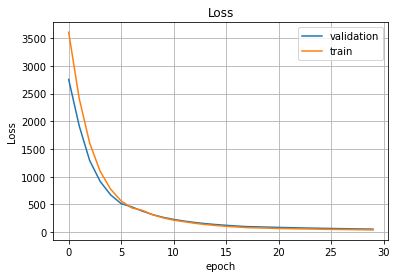

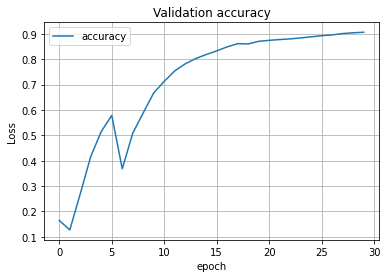

In [198]:
# epoc
for epoc in range(EPOC_NUM):
  if epoc == 18:
    opt_c += 1
    opt = torch.optim.Adam(trajectories_rnn.parameters(), lr=1e-4) # lr=1e-4

  ep_train_loss = []
  ep_val_loss = []
  ep_val_accuracy = []
  start_time = time.time()
  
  trajectories_rnn.train(True) # enable dropout / batch_norm training behavior
  for id_b, batch in enumerate(train_dl):
      opt.zero_grad()
      batch = batch['src'].to(device, torch.float32)

      logp_seq = rnn_loop(trajectories_rnn, batch, device)

      # compute loss
      predictions_logp = logp_seq[:, :-1]
      actual_next_tokens = batch[:, 1:]

      # print(predictions_logp.shape, actual_next_tokens.shape)
      loss = criterion(
          predictions_logp.contiguous().view(-1),
          actual_next_tokens.contiguous().view(-1)
      ) 

      
      # train with backprop
      loss.backward()
      opt.step()
      
      ep_train_loss.append(loss.cpu().data.numpy())
    
  trajectories_rnn.train(False) # enable dropout / batch_norm training behavior
  with torch.no_grad(): 
    for id_b, batch in enumerate(val_dl):
      batch = batch['src'].to(device)

      logp_seq = rnn_loop(trajectories_rnn, batch, device)

      # compute loss
      predictions_logp = logp_seq[:, :-1]
      actual_next_tokens = batch[:, 1:]

      # print(predictions_logp.shape, actual_next_tokens.shape)
      loss = criterion(
          predictions_logp.contiguous().view(-1),
          actual_next_tokens.contiguous().view(-1)
      )
      ep_val_loss.append(loss.cpu().data.numpy())
      ep_val_accuracy.append(np.sum((predictions_logp.cpu().numpy() < Delta + actual_next_tokens.cpu().numpy().astype(float))&(predictions_logp.cpu().numpy() > -Delta + actual_next_tokens.cpu().numpy().astype(float)))/ actual_next_tokens.cpu().numpy().size)
  # print the results for this epoch:
  clear_output(True)
  
  if error > 0:
    print('Warning: the network is hard to learn.')
  if opt_c > 0:
    print('the optimizer changed the step №', opt_c)
  print(f'Epoch {epoc + 1} of {EPOC_NUM} took {time.time() - start_time:.3f}s')
  
  train_loss.append(np.mean(ep_train_loss))
  val_loss.append(np.mean(ep_val_loss))
  val_accuracy.append(np.mean(ep_val_accuracy))
  plot_train_process(train_loss, val_loss)

  if train_loss[0] < train_loss[-1]:
    error+=1
    assert error!=3, "RNN didn't converge."

In [199]:
print('new finally loss train = ', train_loss[-1], 'new finally loss validation = ', val_loss[-1])

new finally loss train =  38.67684 new finally loss validation =  52.932877


In [200]:
print('old finally loss train = ', train_loss[-1], 'old finally loss validation = ', val_loss[-1])

old finally loss train =  38.67684 old finally loss validation =  52.932877
